# Our Hypothesis: A* finds always the 'ShortBest' path!

Let's see, if this is true ...

In [1]:
#!pip install pandas

In [2]:
# Importations
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pandas as pd

from algorithms import *
from classes import *
from utils import *
from env_levels import *

# Our Static Environment

We've developed a custom environment using the **Minihack level editor** to gain precise control over our work. The environment we're working on is a 15x15 **fully observable maze**, where the agent navigates through the grid while avoiding hazardous **lava pools**.

The agent starts in the *top left corner* and needs to find the stairs in the *bottom right corner* while avoiding lava pools. 

Inside *env_levels.py* there is the *'.des-file'*:

* Agent: '@'
* Target: '>'
* Floor tile: '.'
* Walls: '-' and '|'
* Lava pools: 'L'

> As part of our exploration, we're committed to introducing and navigating through **various levels of complexity**. This initiative allows us to test and implement different search algorithms tailored to the evolving challenges presented by each level. This dynamic approach not only showcases the adaptability of our agent but also facilitates a comprehensive evaluation of its problem-solving capabilities across diverse scenarios.

For now, we: 
* initialize the specific map configuration
* set a random seed for reproducibility
* reset the environment to get the initial observation
* render the environment for visual representation

In [3]:
env_lv1 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv1,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv1.seed(42)
obs_lv1 = env_lv1.reset() #each reset generates a new environment instance
env_lv1.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}.........|                                                                 
|.....}.....}.|                                                                 
|}............|                                                                 
|.}.......}...|                                                                 
|...}}..}.....|                                                                 
|.}.........}.|                                                                 
|....}..}.....|                                                                 
|.}........}.}|            

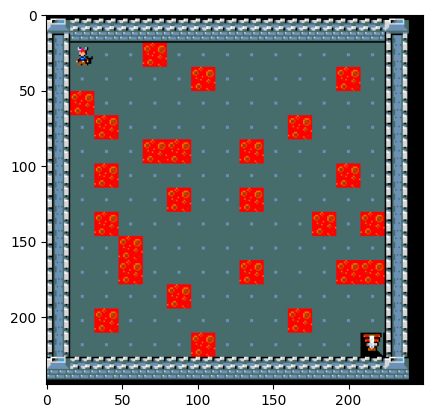

In [4]:
plt.imshow(obs_lv1['pixel'][45:290, 0:250]) #Plots directly from minihack generator

In [5]:
game = obs_lv1['pixel']

In [6]:
comparison_case1 = []
comparison_case2 = []
comparison_case3 = []
algorithms = ['Breadth First Search (UA)', 'Uniform Cost Search (UA)', 'A* (IA)', 'Greedy Best First Search (IA)']
time_case1 = []
path_case1 = []
time_case2 = []
path_case2 = []
time_case3 = []
path_case3 = []

## A GridWorld Problem

To streamline the implementation of search algorithms in our agent, we've established a problem definition encapsulated within a class. Specifically, we've conceptualized our problem using a **GridWorldProblem class**. This class serves as a foundation for formulating the problem in a way that aligns with the principles of graph search algorithms.

As these search algorithms operate on graphs, we visualize the **corresponding graph of the agent's environment**. This graph effectively represents the navigable nodes within the maze, and we highlight the coordinates of each node for clarity. The edges connecting these states within the graph are assigned a uniform cost of 1.

In our case we will consider the _chars_ representation, a multi-dimensional array containing the ASCII encoding of the characters. More specifically:

* Agent: ASCII 64
* Stairs: ASCII 62
* Walls: ASCII
* Lava: ASCII 125

> To ensure an accurate and meaningful representation of the maze environment within the graph, we undertake a crucial **preprocessing step**. This step involves meticulous manipulation of the Minihack matrix, allowing us to narrow our focus exclusively to the observable aspects of the environment.

In [7]:
game_map_lv1 = process_matrix(obs_lv1['chars'])
print(game_map_lv1)

[[ 45  45  45  45  45  45  45  45  45  45  45  45  45  45  45]
 [124  64  46  46 125  46  46  46  46  46  46  46  46  46 124]
 [124  46  46  46  46  46 125  46  46  46  46  46 125  46 124]
 [124 125  46  46  46  46  46  46  46  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46 125  46  46  46 124]
 [124  46  46  46 125 125  46  46 125  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46  46  46 125  46 124]
 [124  46  46  46  46 125  46  46 125  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46  46 125  46 125 124]
 [124  46  46 125  46  46  46  46  46  46  46  46  46  46 124]
 [124  46  46 125  46  46  46  46 125  46  46  46 125 125 124]
 [124  46  46  46  46 125  46  46  46  46  46  46  46  46 124]
 [124  46 125  46  46  46  46  46  46  46 125  46  46  46 124]
 [124  46  46  46  46  46 125  46  46  46  46  46  46  62 124]
 [ 45  45  45  45  45  45  45  45  45  45  45  45  45  45  45]]


In [8]:
process_matrix(obs_lv1['colors'])
# 6 -> blue
# 1 -> red
game_map_lv1_colors = process_matrix(obs_lv1['colors'])

Initial state: (1, 1)
Goal state: (13, 13)


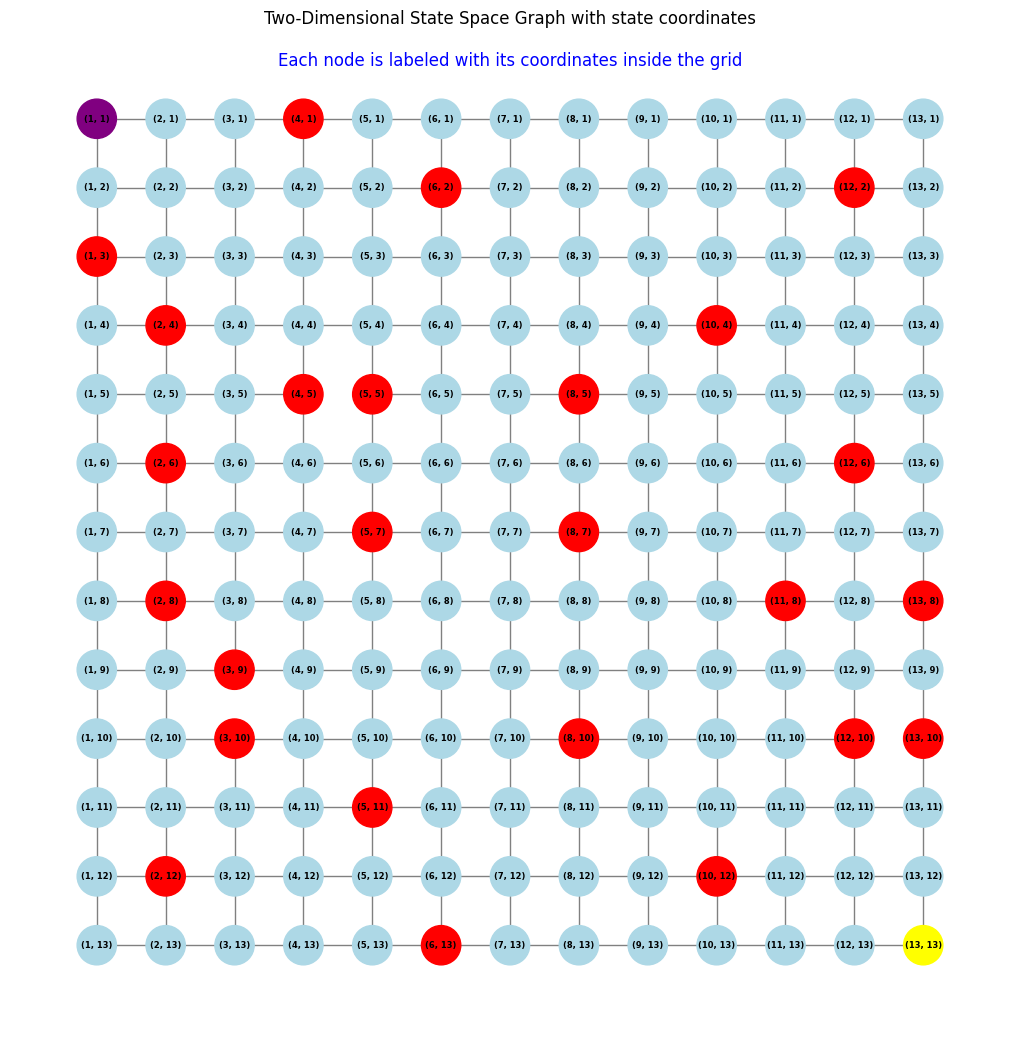

In [9]:
grid_problem1 = GridWorldProblem(game_map_lv1, find_state_coord(game_map_lv1, ord('@')), find_state_coord(game_map_lv1, ord('>')), game_map_lv1_colors)

print("Initial state:", grid_problem1.initial_state)
print("Goal state:", grid_problem1.goal_state)

basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)

plot_graph(basic_graph)

## <u> CASE 1 </u>

### Uninformed Agent (Breadth-First-Search)

Our uninformed agent employs the Breadth-First Search (BFS) algorithm to navigate through the grid world problem.

* Red Nodes: Lava pools.
* Green Nodes: Nodes visited by the agent
* Blue Node: Initial position of the agent

> This visualization provides a clear depiction of the agent's exploration process, distinguishing between hazardous areas (lava pools), traversed paths, and the starting point of the agent. The Breadth-First Search algorithm ensures a systematic exploration of the grid, contributing to efficient pathfinding in our maze-like environment.

Time: 0.004628 seconds
The found path is long 40.


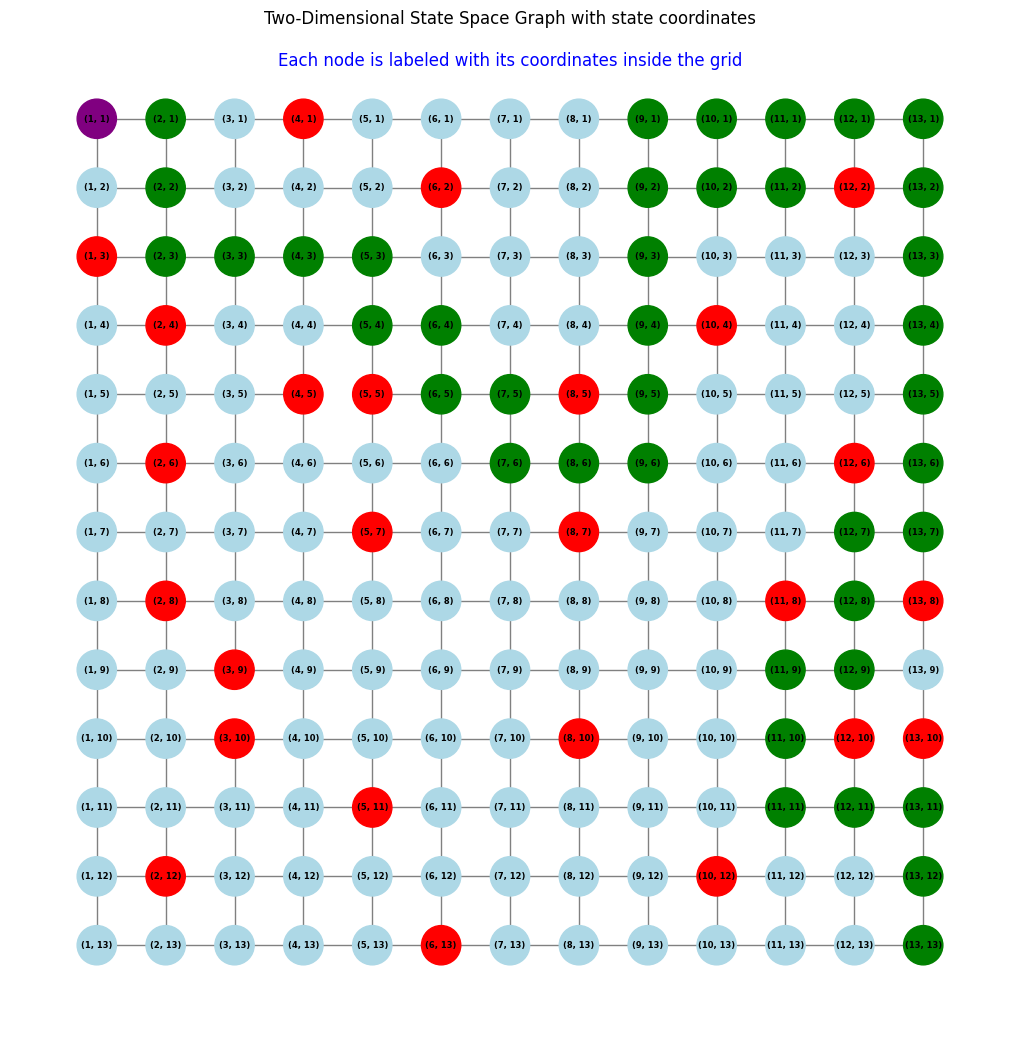

In [10]:
uninformed_agent = UninformedSearchAgent(grid_problem1) # Instantiate an Uninformed Search Agent

solution_path = uninformed_agent.search(breadth_first_search) # Perform uniformed search with the Breadth-First Search

time_case1.append(uninformed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

plot_graph(explored_graph) # Plot the graph with both basic and explored nodes

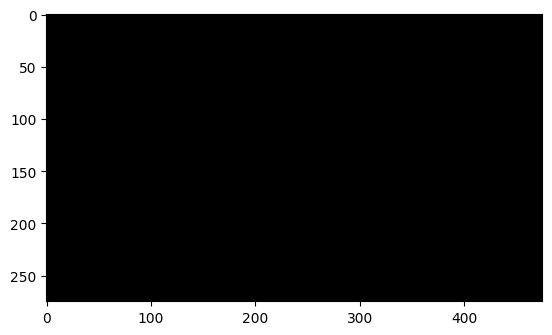

In [11]:
# PLOT
actions = actions_from_path(find_state_coord(game_map_lv1, ord('@')), solution_path)

import IPython.display as display

image = plt.imshow(game[25:300, :475])
for action in actions:
    s, _, _, _ = env_lv1.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][25:300, :475])
    time.sleep(0.3)

### Uninformed Agent (Dijkstra's Algorithm) 

Time: 0.006853 seconds
The taken path has the length 24 (steps).


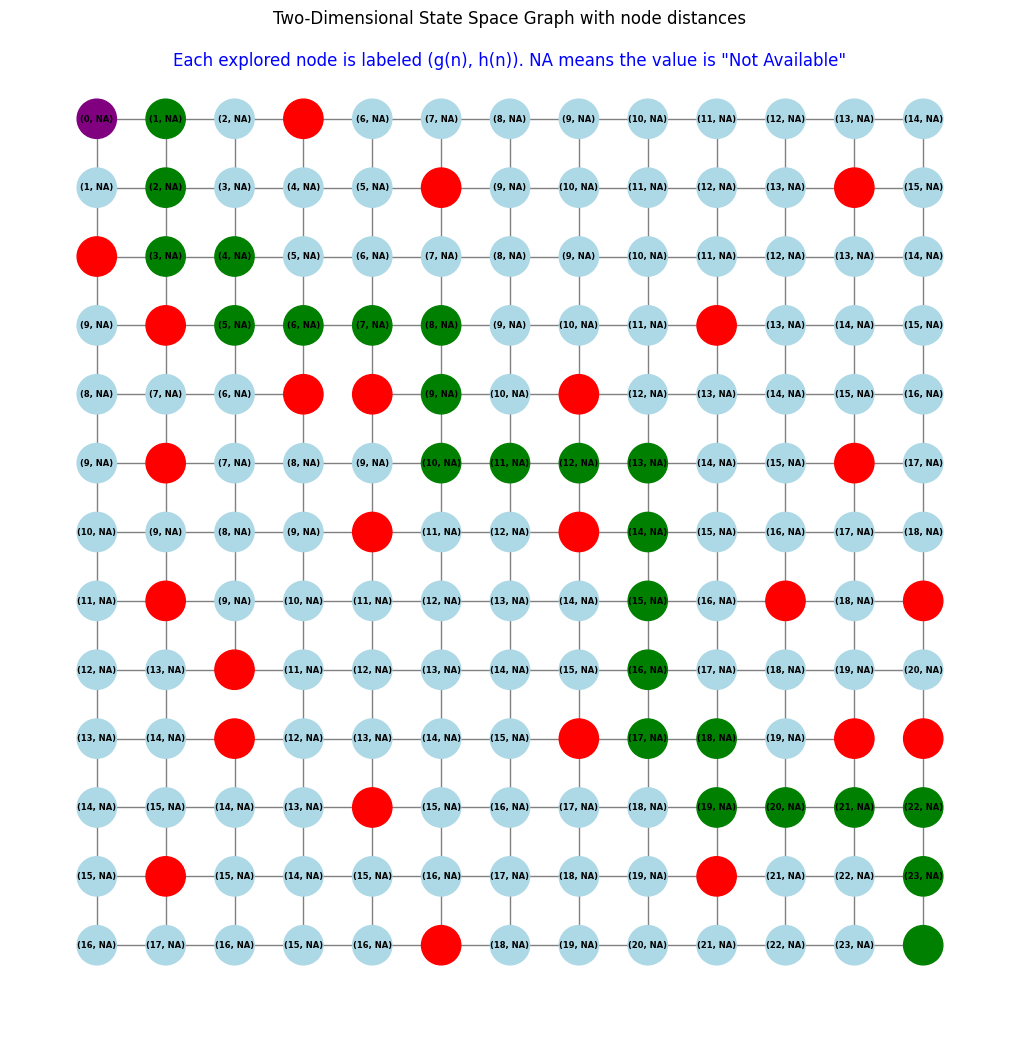

In [12]:
uninformed_agent = UninformedSearchAgent(grid_problem1)
solution_path, node_distances = uninformed_agent.search(uniform_cost_search)

time_case1.append(uninformed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The taken path has the length {len(solution_path)} (steps).')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (A*)

1
(2, 1) 1
1
(1, 2) 1
1
(3, 1) 2
inf
(1, 1) inf
1
(2, 2) 2
1
(2, 2) 2
inf
(1, 1) inf
1
(2, 1) 3
1
(3, 2) 3
1
(3, 2) 3
1
(1, 2) 3
1
(2, 3) 3
1
(2, 1) 3
1
(4, 2) 4
1
(2, 2) 4
1
(3, 3) 4
1
(3, 1) 4
1
(4, 3) 5
1
(2, 3) 5
1
(3, 4) 5
1
(3, 2) 5
1
(3, 3) 4
1
(2, 2) 4
1
(4, 4) 6
1
(3, 5) 6
1
(3, 3) 6
1
(5, 4) 7
1
(3, 4) 7
1
(4, 3) 7
1
(2, 5) 7
1
(3, 6) 7
1
(3, 4) 7
1
(6, 4) 8
1
(4, 4) 8
1
(5, 3) 8
1
(5, 2) 5
1
(3, 2) 5
1
(4, 3) 5
1
(5, 3) 6
1
(3, 3) 6
1
(4, 4) 6
1
(4, 2) 6
1
(4, 6) 8
1
(3, 7) 8
1
(3, 5) 8
1
(5, 6) 9
1
(3, 6) 9
1
(4, 7) 9
1
(4, 7) 9
1
(2, 7) 9
1
(3, 8) 9
1
(3, 6) 9
1
(6, 6) 10
1
(4, 6) 10
1
(3, 7) 10
1
(4, 8) 10
1
(4, 6) 10
1
(4, 8) 10
1
(3, 7) 10
1
(4, 2) 6
1
(5, 3) 6
1
(5, 1) 6
1
(6, 3) 7
1
(4, 3) 7
1
(5, 4) 7
1
(5, 2) 7
1
(7, 4) 9
1
(5, 4) 9
1
(6, 5) 9
1
(6, 3) 9
1
(7, 6) 11
1
(5, 6) 11
1
(6, 7) 11
1
(6, 5) 11
1
(7, 5) 10
1
(6, 6) 10
1
(6, 4) 10
1
(7, 3) 8
1
(5, 3) 8
1
(6, 4) 8
1
(8, 6) 12
1
(6, 6) 12
1
(7, 7) 12
1
(7, 5) 12
1
(9, 6) 13
1
(7, 6) 13
1
(6, 7) 13
1
(7, 8) 13
1


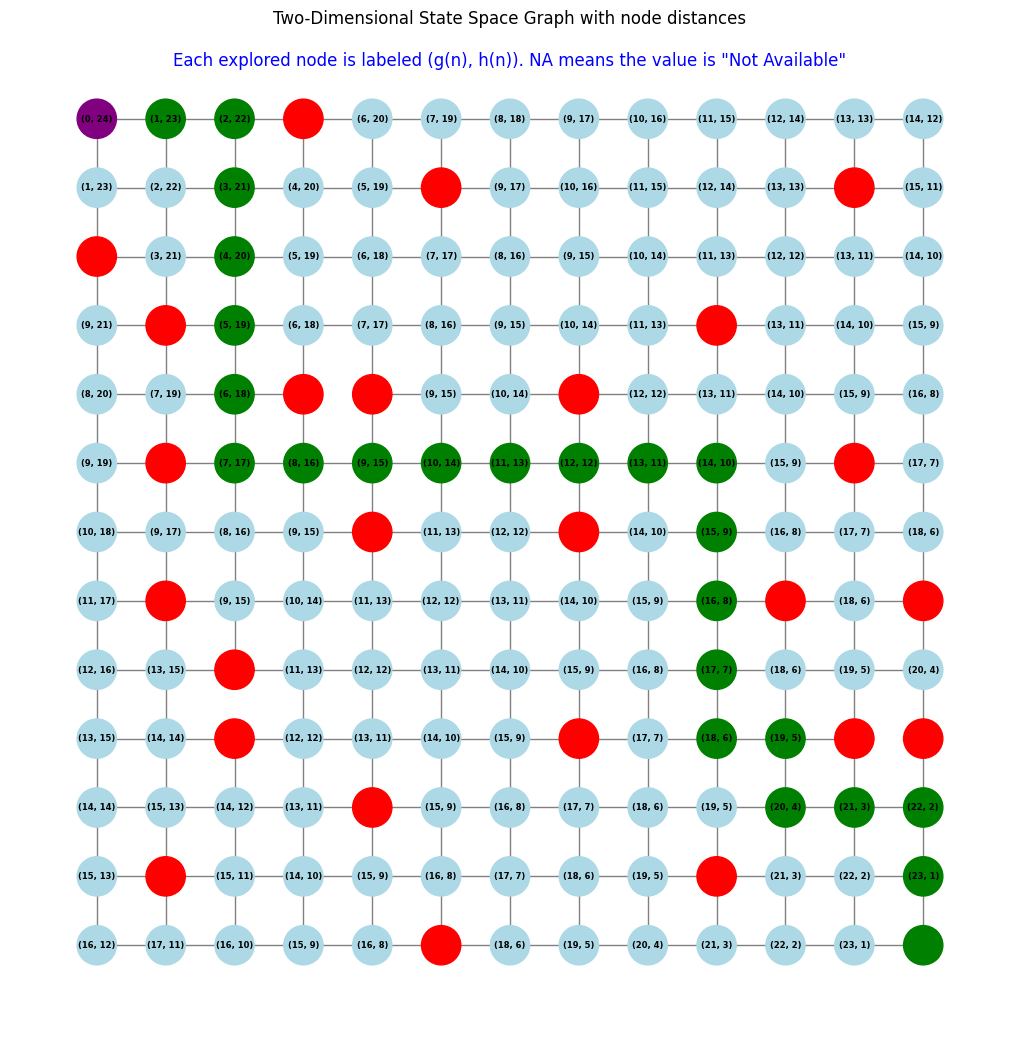

In [13]:
informed_agent = InformedSearchAgent(grid_problem1)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(astar_search, manhattan_distance)

time_case1.append(informed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)


# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (Greedy Best First Search)

Time: 0.000864 seconds
The found path is long 28


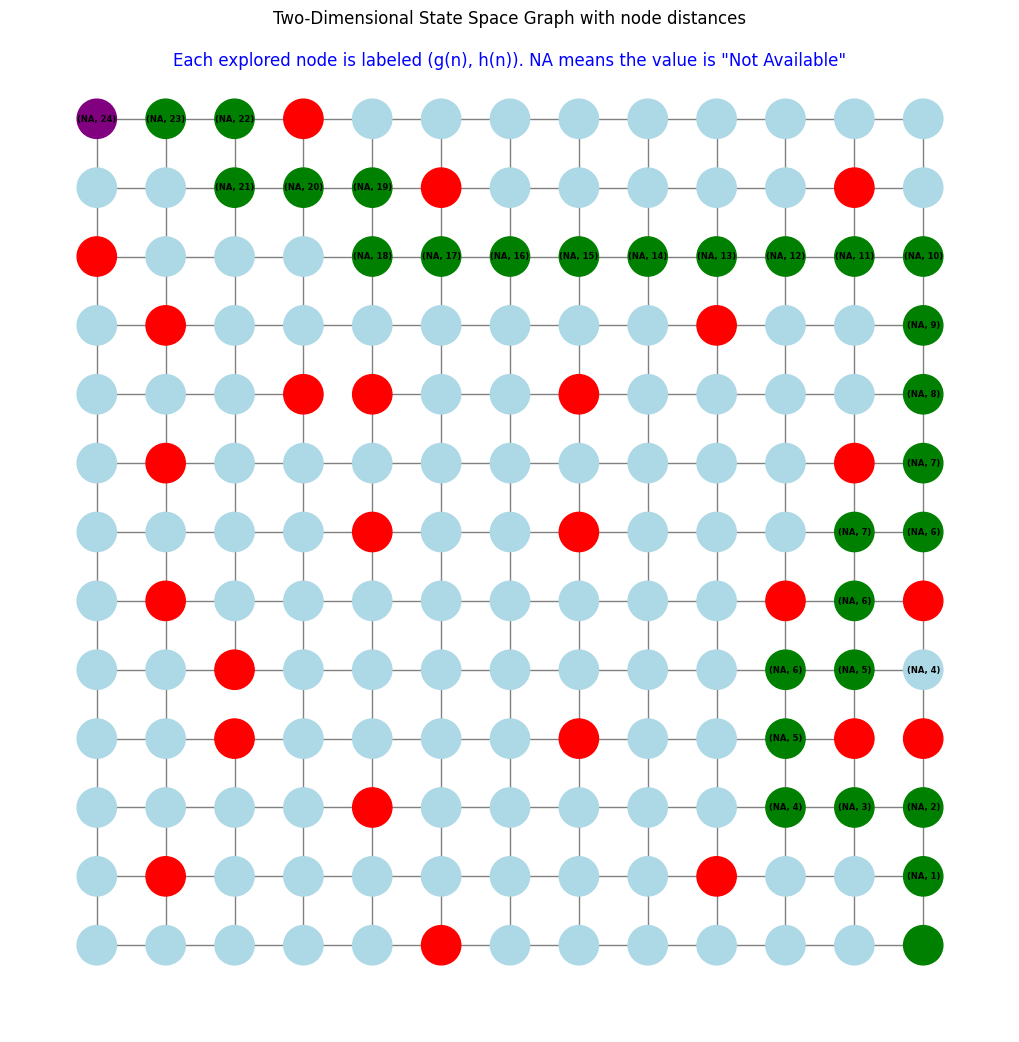

In [14]:
informed_agent = InformedSearchAgent(grid_problem1)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(greedy_best_first_search, manhattan_distance)

time_case1.append(informed_agent.execution_time())
path_case1.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem1, grid_problem1.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

## CASE 1: Performance Evaluation and Comparison of Search Algorithms

In [15]:
comparison_case1.append(algorithms)
comparison_case1.append(time_case1)
comparison_case1.append(path_case1)
df_case1 = pd.DataFrame()
df_case1['Algorithm'] = algorithms
df_case1['Execution Time'] = time_case1
df_case1['Path Length'] = path_case1
df_case1.set_index('Algorithm', inplace=True)
df_case1

Execution Time  Path Length
Algorithm                                                 
Breadth First Search (UA)            0.004628           40
Uniform Cost Search (UA)             0.006853           24
A* (IA)                              0.017437           24
Greedy Best First Search (IA)        0.000864           28

## <u> CASE 2 </u>
To increase the complexity of the environment and to test, how the algorithms work, we add more lava pools.

In [16]:
env_lv2 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv2,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv2.seed(42)
obs_lv2 = env_lv2.reset() #each reset generates a new environment instance
env_lv2.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}...}.}...|                                                                 
|.....}.....}.|                                                                 
|}..}.}.......|                                                                 
|.}.......}..}|                                                                 
|...}}..}.....|                                                                 
|..}........}.|                                                                 
|..}.}...}}...|                                                                 
|.}..}..}}.}..|            

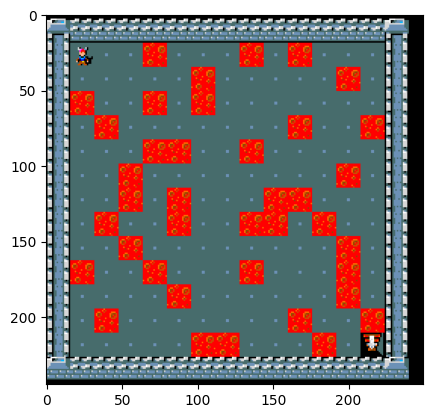

In [17]:
plt.imshow(obs_lv2['pixel'][45:290, 0:250]) #Plots directly from minihack generator

game_map_lv2 = process_matrix(obs_lv2['chars'])

game_map_lv2_colors = process_matrix(obs_lv2['colors'])

Initial state: (1, 1)
Goal state: (13, 13)


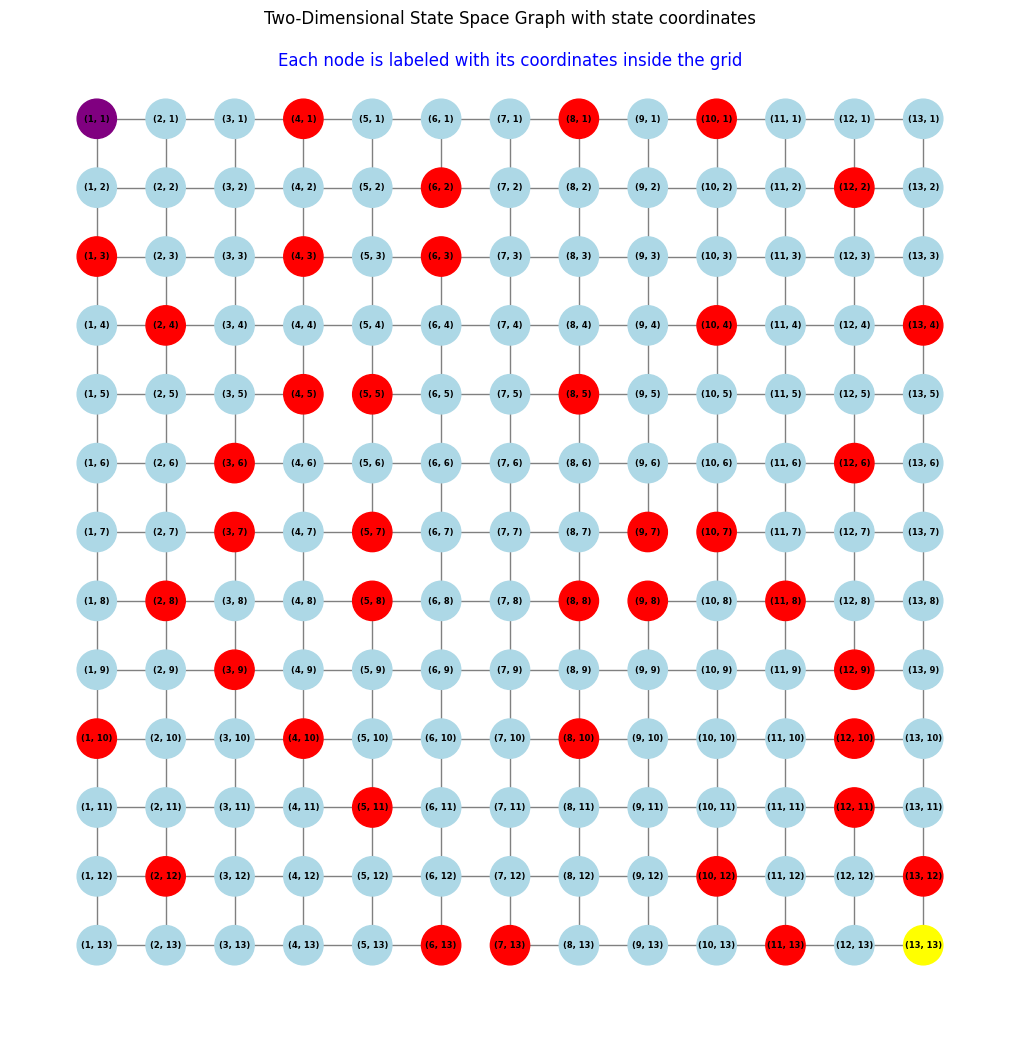

In [18]:
grid_problem2 = GridWorldProblem(game_map_lv2, find_state_coord(game_map_lv2, ord('@')), find_state_coord(game_map_lv2, ord('>')), game_map_lv2_colors)

print("Initial state:", grid_problem2.initial_state)
print("Goal state:", grid_problem2.goal_state)

basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)

plot_graph(basic_graph)

### Uninformed Agent (Breadth-First-Search)

Time: 0.004867 seconds
The found path is long 30.


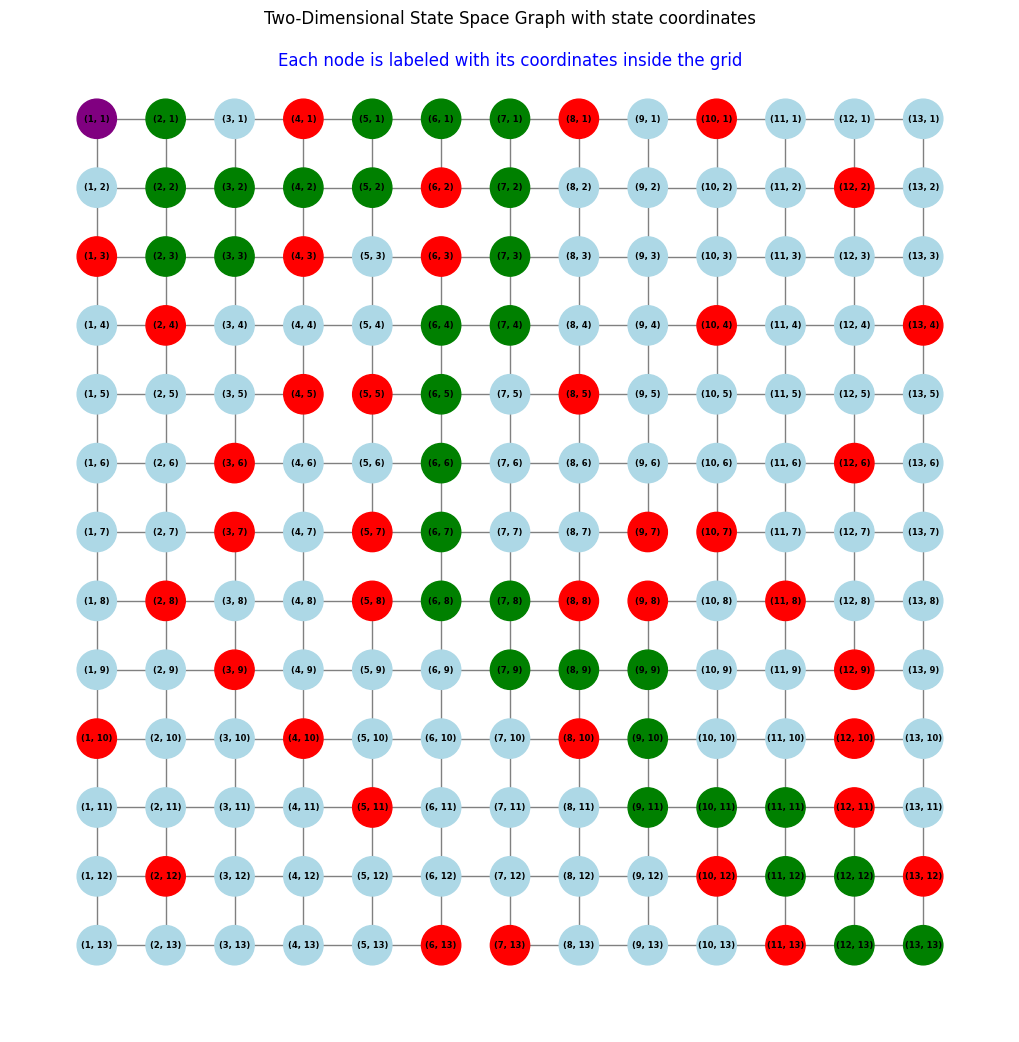

In [19]:

uninformed_agent = UninformedSearchAgent(grid_problem2) # Instantiate an Uninformed Search Agent

solution_path = uninformed_agent.search(breadth_first_search) # Perform uniformed search with the Breadth-First Search

time_case2.append(uninformed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

plot_graph(explored_graph) # Plot the graph with both basic and explored nodes

### Uninformed Agent (Dijkstra's Algorithm)

Time: 0.006419 seconds
The found path is long 24.


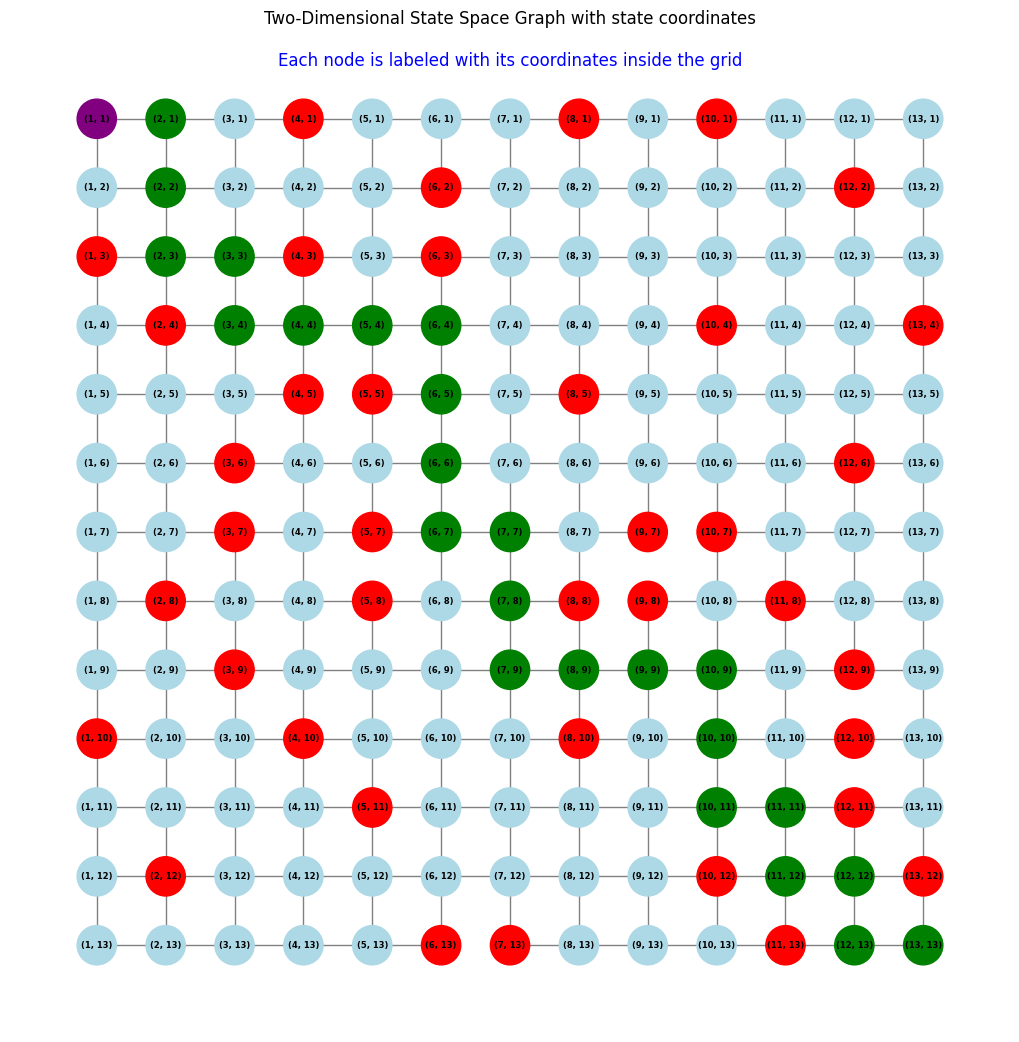

In [20]:
uninformed_agent = UninformedSearchAgent(grid_problem2)
solution_path, node_distances = uninformed_agent.search(uniform_cost_search)

time_case2.append(uninformed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph(explored_graph)

### Informed Agent (A*)

1
(2, 1) 1
1
(1, 2) 1
1
(3, 1) 2
inf
(1, 1) inf
1
(2, 2) 2
1
(2, 2) 2
inf
(1, 1) inf
1
(2, 1) 3
1
(3, 2) 3
1
(3, 2) 3
1
(1, 2) 3
1
(2, 3) 3
1
(2, 1) 3
1
(4, 2) 4
1
(2, 2) 4
1
(3, 3) 4
1
(3, 1) 4
1
(2, 3) 5
1
(3, 4) 5
1
(3, 2) 5
1
(3, 3) 4
1
(2, 2) 4
1
(5, 2) 5
1
(3, 2) 5
1
(4, 2) 6
1
(5, 3) 6
1
(5, 1) 6
1
(4, 4) 6
1
(3, 5) 6
1
(3, 3) 6
1
(5, 4) 7
1
(5, 2) 7
1
(5, 4) 7
1
(3, 4) 7
1
(2, 5) 7
1
(3, 4) 7
1
(6, 4) 8
1
(4, 4) 8
1
(5, 3) 8
1
(7, 4) 9
1
(5, 4) 9
1
(6, 5) 9
1
(8, 4) 10
1
(6, 4) 10
1
(7, 5) 10
1
(7, 3) 10
1
(7, 5) 10
1
(6, 6) 10
1
(6, 4) 10
1
(6, 5) 11
1
(7, 6) 11
1
(7, 4) 11
1
(7, 6) 11
1
(5, 6) 11
1
(6, 7) 11
1
(6, 5) 11
1
(8, 6) 12
1
(6, 6) 12
1
(7, 7) 12
1
(7, 5) 12
1
(7, 7) 12
1
(6, 8) 12
1
(6, 6) 12
1
(9, 4) 11
1
(7, 4) 11
1
(8, 3) 11
1
(9, 6) 13
1
(7, 6) 13
1
(8, 7) 13
1
(8, 7) 13
1
(6, 7) 13
1
(7, 8) 13
1
(7, 6) 13
1
(7, 7) 14
1
(8, 6) 14
1
(6, 8) 14
1
(7, 9) 14
1
(7, 7) 14
1
(8, 4) 12
1
(9, 5) 12
1
(9, 3) 12
1
(10, 6) 14
1
(8, 6) 14
1
(9, 5) 14
1
(8, 9) 15
1
(6, 9) 15
1

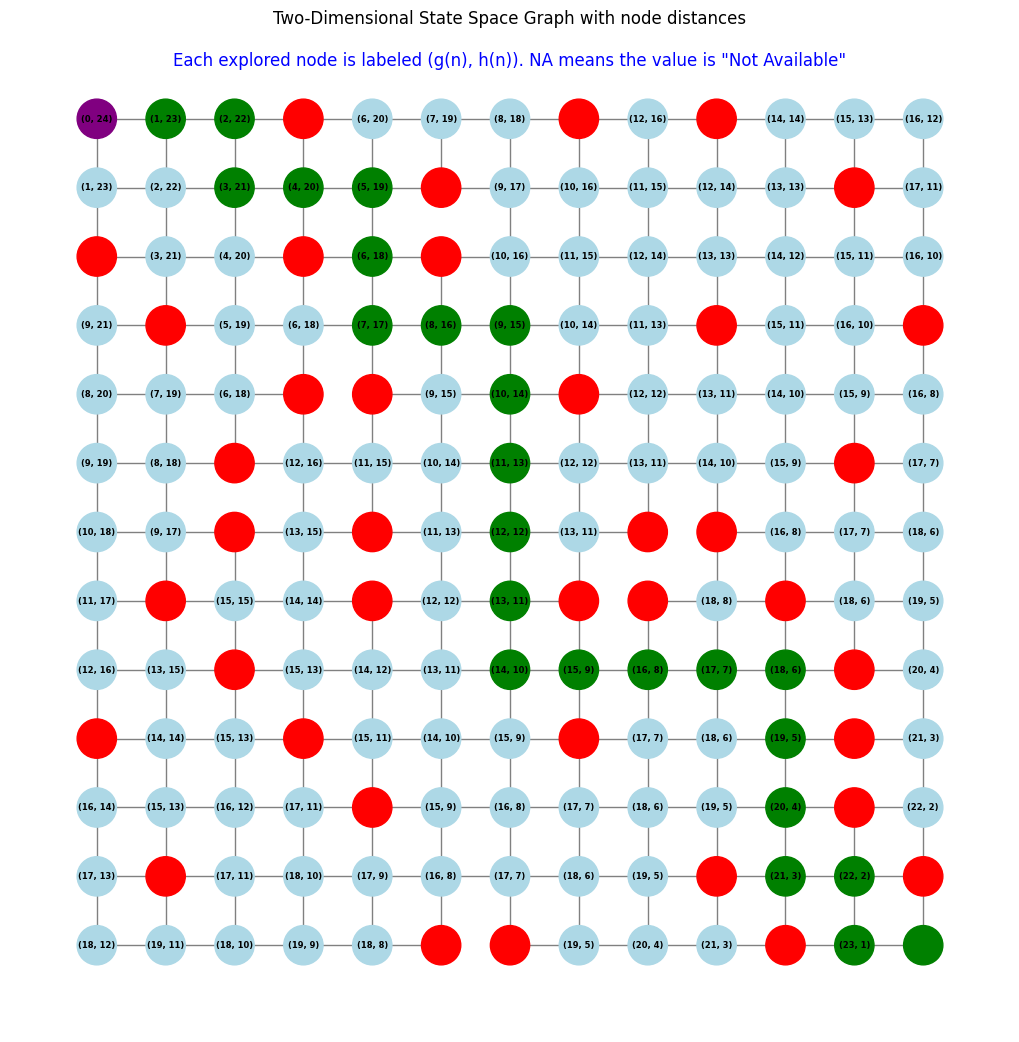

In [21]:
informed_agent = InformedSearchAgent(grid_problem2)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(astar_search, manhattan_distance)

time_case2.append(informed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (Greedy Best-First Search)

Time: 0.001802 seconds
The found path is long 28


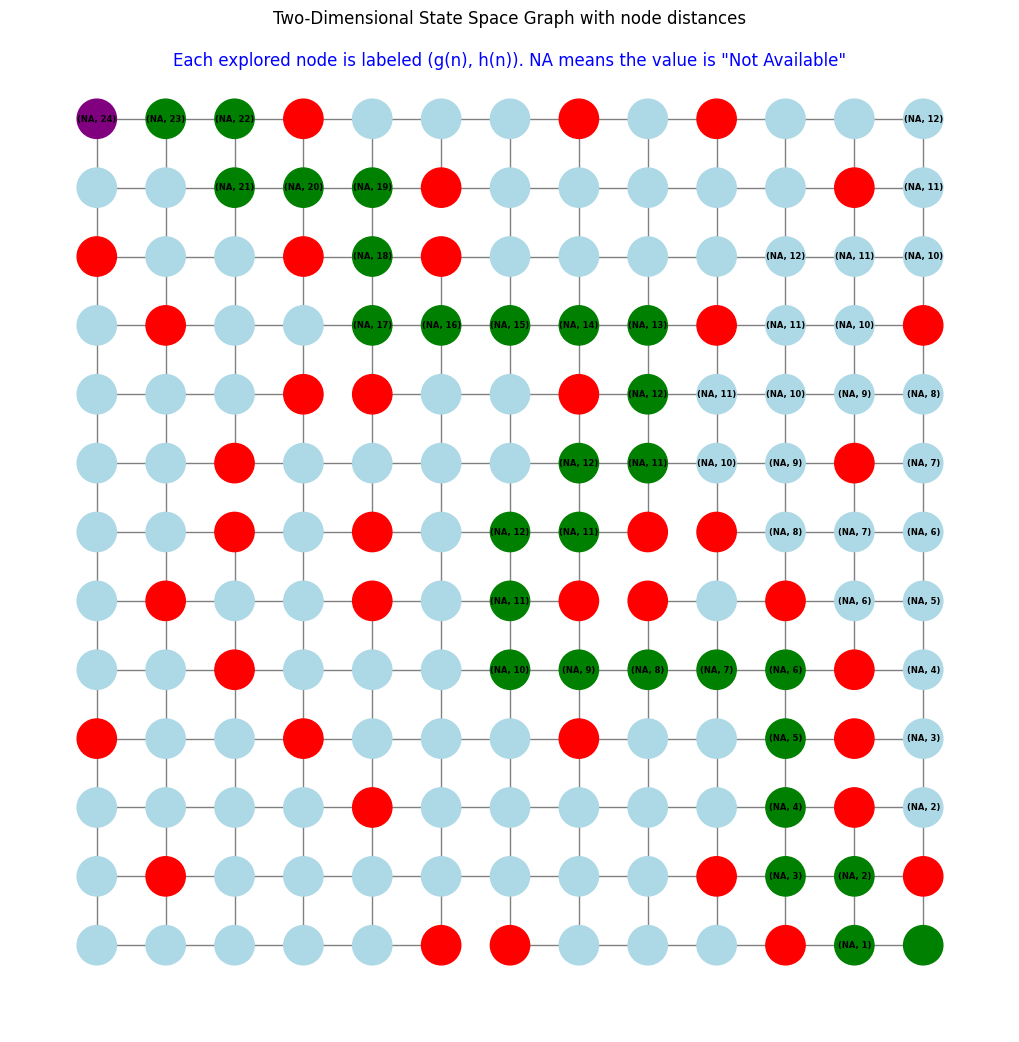

In [22]:
informed_agent = InformedSearchAgent(grid_problem2)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(greedy_best_first_search, manhattan_distance)

time_case2.append(informed_agent.execution_time())
path_case2.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem2, grid_problem2.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

In [23]:
comparison_case2.append(algorithms)
comparison_case2.append(time_case2)
comparison_case2.append(path_case2)
df_case2 = pd.DataFrame()
df_case2['Algorithm'] = algorithms
df_case2['Execution Time'] = time_case2
df_case2['Path Length'] = path_case2
df_case2.set_index('Algorithm', inplace=True)
df_case2

Execution Time  Path Length
Algorithm                                                 
Breadth First Search (UA)            0.004867           30
Uniform Cost Search (UA)             0.006419           24
A* (IA)                              0.025503           24
Greedy Best First Search (IA)        0.001802           28

## <u> CASE 3 </u>
### Create the Environment


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
---------------                                                                 
|@..}...}.}...|                                                                 
|.....}.....}.|                                                                 
|}..}.}.......|                                                                 
|.}.......}..}|                                                                 
|...}}..}.....|                                                                 
|..}........}.|                                                                 
|..}.}...}}...|                                                                 
|.}..}..}}.}..|            

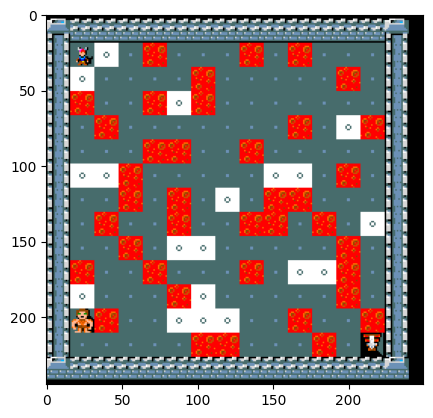

In [24]:
env_lv3 = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file_static_lv4,
    #max_episode_steps=50,
    observation_keys =("chars", "colors", "specials", "pixel")
)

env_lv3.seed(42)
obs_lv3 = env_lv3.reset() #each reset generates a new environment instance
env_lv3.render()

plt.imshow(obs_lv3['pixel'][45:290, 0:250]) #Plots directly from minihack generator

game_map_lv3 = process_matrix(obs_lv3['chars'])
game_map_lv3_colors = process_matrix(obs_lv3['colors'])

### General Problem

Initial state: (1, 1)
Goal state: (13, 13)


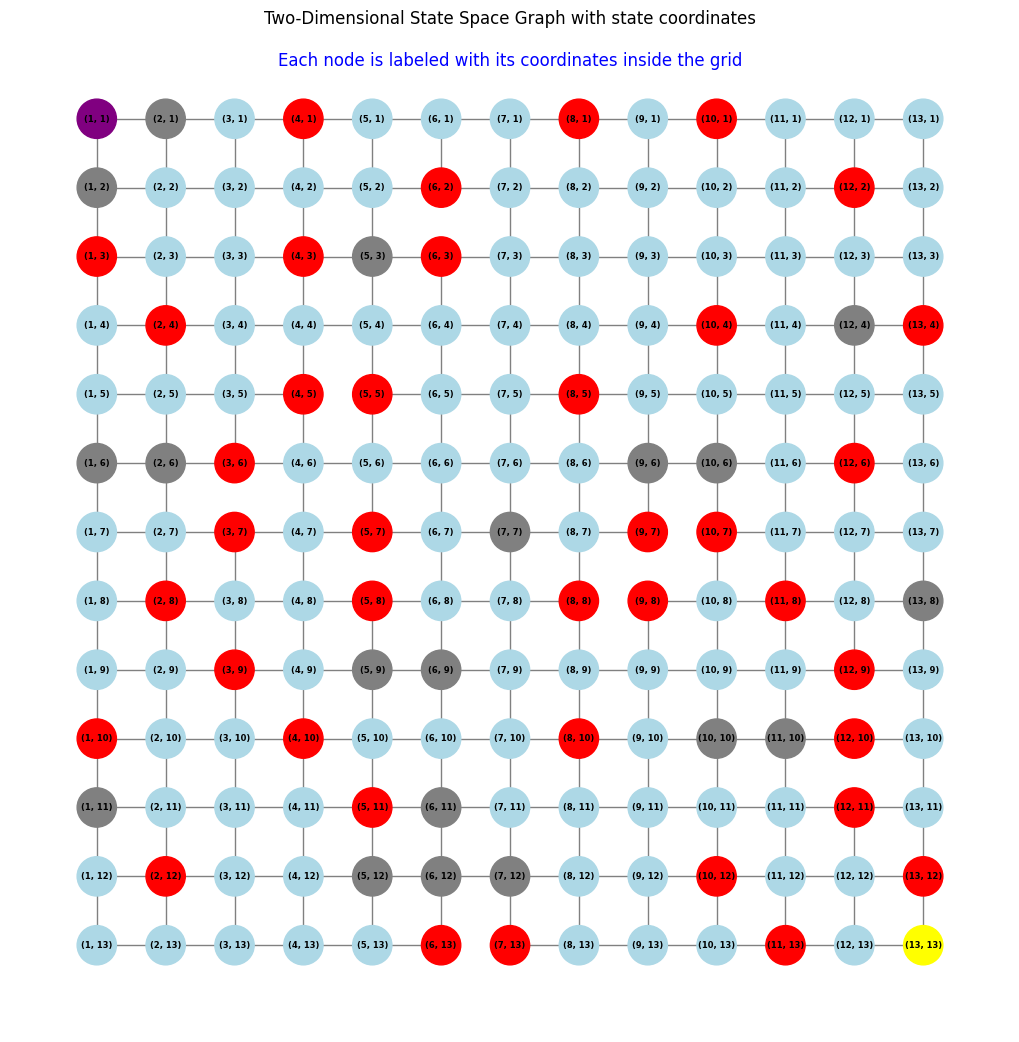

In [25]:
# Instantiate a problem from class GridWorldProblem
grid_problem3 = GridWorldProblem(game_map_lv3, find_state_coord(game_map_lv3, ord('@')), find_state_coord(game_map_lv3, ord('>')), game_map_lv3_colors)

print("Initial state:", grid_problem3.initial_state)
print("Goal state:", grid_problem3.goal_state)

# Create the basic graph
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)

plot_graph(basic_graph)

### Uninformed Agent (Breadth-First Search)

Time: 0.003752 seconds
The found path is long 30.


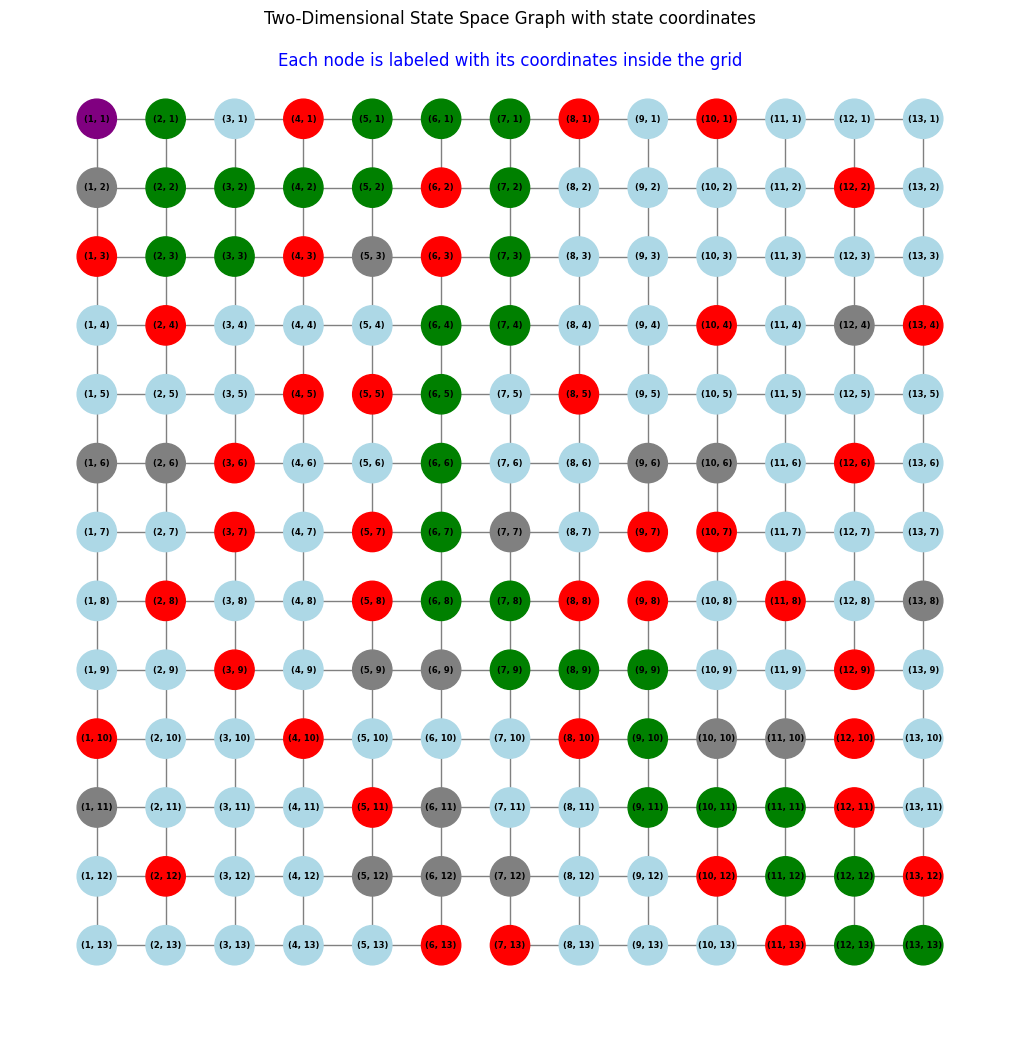

In [26]:
uninformed_agent = UninformedSearchAgent(grid_problem3)
solution_path = uninformed_agent.search(breadth_first_search)

time_case3.append(uninformed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The found path is long {len(solution_path)}.')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph(explored_graph)

### Uninformed Agent (Dijkstra's Algorithm)

Time: 0.008351 seconds
The taken path has the length 24 (steps).


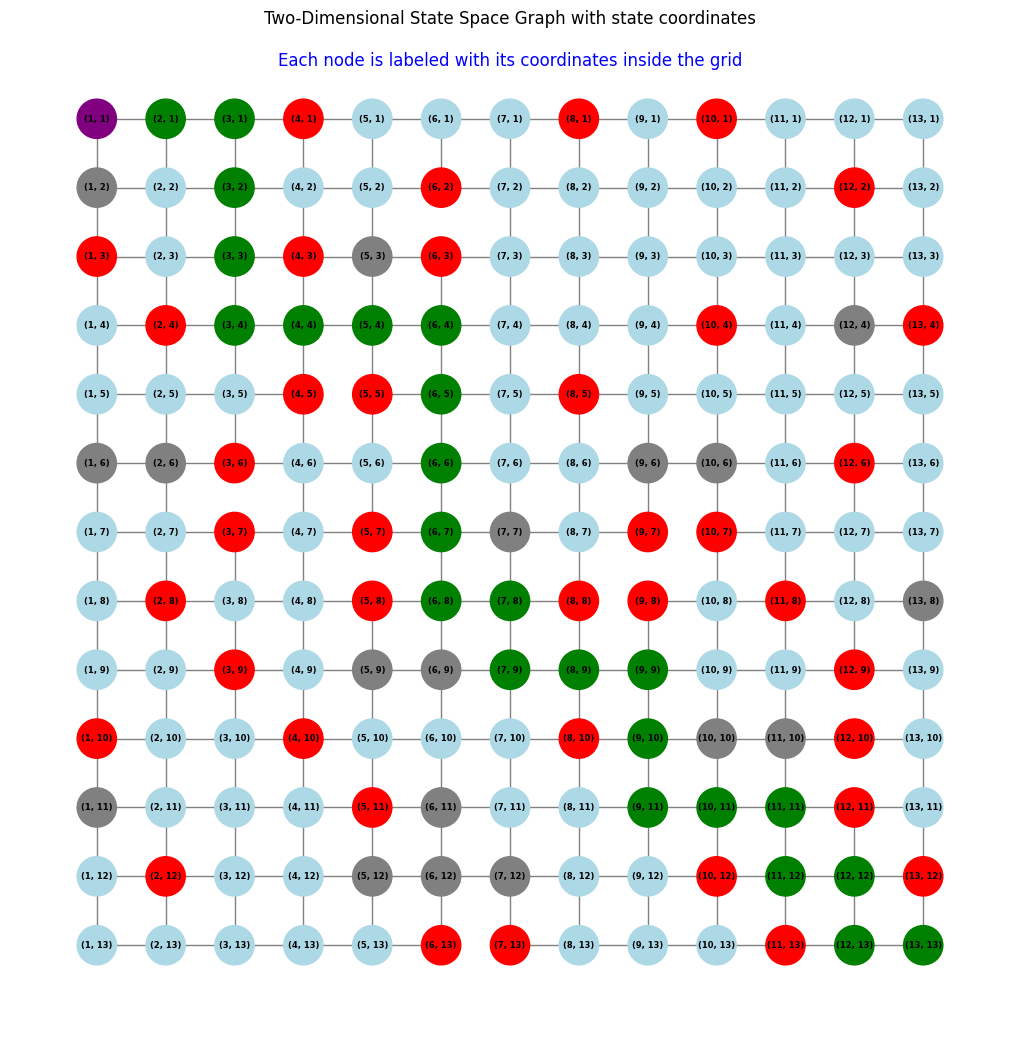

In [27]:
uninformed_agent = UninformedSearchAgent(grid_problem3)
solution_path, node_distances = uninformed_agent.search(uniform_cost_search)

time_case3.append(uninformed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {uninformed_agent.execution_time()} seconds')
print(f'The taken path has the length {len(solution_path)} (steps).')

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph(explored_graph)

### Informed Agent (A*)

3
(2, 1) 3
3
(1, 2) 3
1
(3, 1) 4
inf
(1, 1) inf
1
(2, 2) 4
1
(2, 2) 4
inf
(1, 1) inf
3
(2, 1) 7
1
(3, 2) 5
1
(3, 2) 5
3
(1, 2) 7
1
(2, 3) 5
3
(2, 1) 7
1
(4, 2) 6
1
(2, 2) 6
1
(3, 3) 6
1
(3, 1) 6
1
(2, 3) 7
1
(3, 4) 7
1
(3, 2) 7
1
(3, 3) 6
1
(2, 2) 6
1
(5, 2) 7
1
(3, 2) 7
1
(4, 2) 8
3
(5, 3) 10
1
(5, 1) 8
1
(4, 4) 8
1
(3, 5) 8
1
(3, 3) 8
1
(5, 4) 9
1
(3, 4) 9
1
(2, 5) 9
1
(3, 4) 9
1
(6, 4) 10
1
(4, 4) 10
3
(5, 3) 12
1
(7, 4) 11
1
(5, 4) 11
1
(6, 5) 11
1
(8, 4) 12
1
(6, 4) 12
1
(7, 5) 12
1
(7, 3) 12
1
(7, 5) 12
1
(6, 6) 12
1
(6, 4) 12
1
(6, 5) 13
1
(7, 6) 13
1
(7, 4) 13
1
(7, 6) 13
1
(5, 6) 13
1
(6, 7) 13
1
(6, 5) 13
1
(8, 6) 14
1
(6, 6) 14
3
(7, 7) 16
1
(7, 5) 14
3
(7, 7) 16
1
(6, 8) 14
1
(6, 6) 14
1
(9, 4) 13
1
(7, 4) 13
1
(8, 3) 13
3
(9, 6) 17
1
(7, 6) 15
1
(8, 7) 15
1
(7, 8) 15
3
(6, 9) 17
1
(6, 7) 15
1
(8, 4) 14
1
(9, 5) 14
1
(9, 3) 14
3
(7, 7) 18
1
(8, 6) 16
1
(6, 8) 16
1
(7, 9) 16
3
(7, 7) 18
1
(10, 5) 15
3
(9, 6) 17
1
(9, 4) 15
1
(8, 9) 17
3
(6, 9) 19
1
(7, 10) 17
1
(7, 8) 17
1
(

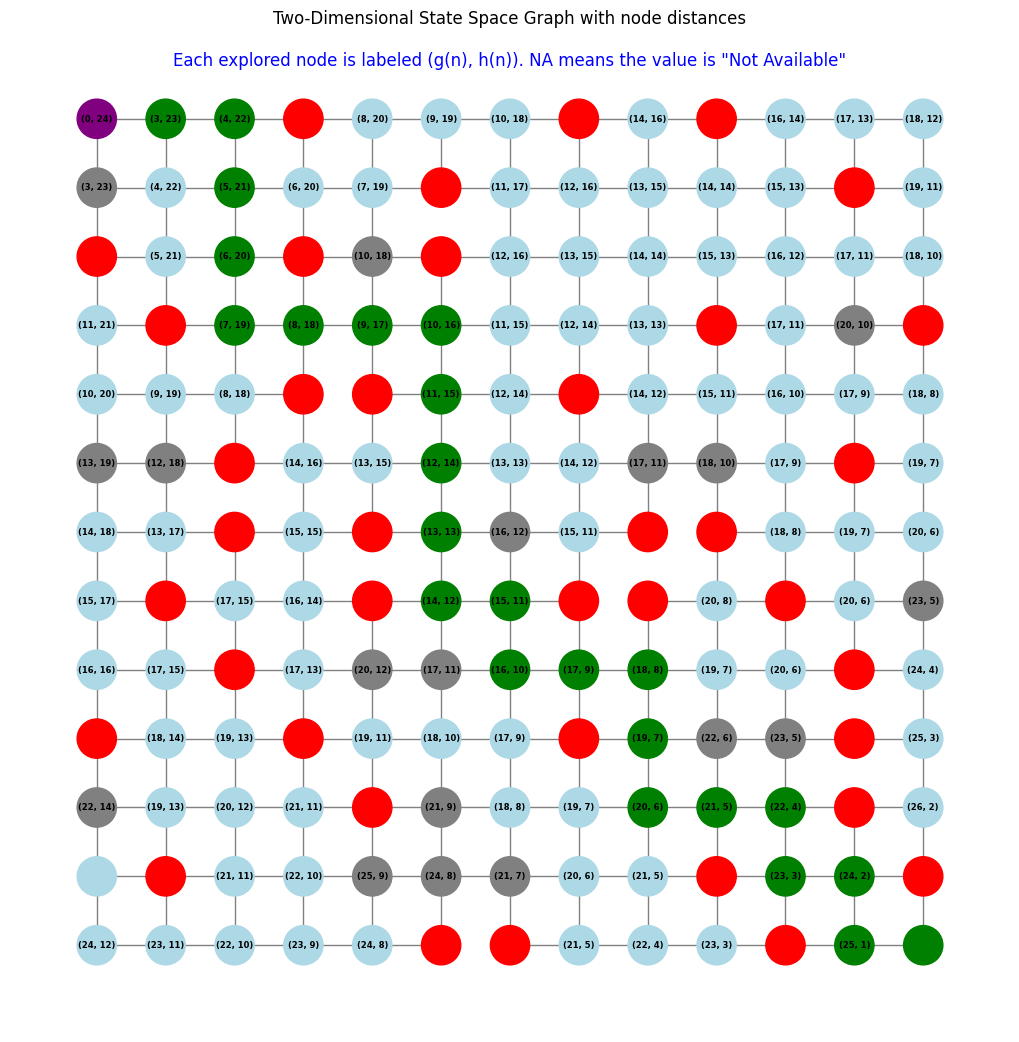

In [28]:
informed_agent = InformedSearchAgent(grid_problem3)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(astar_search, manhattan_distance)

time_case3.append(informed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

### Informed Agent (Greedy Best-First-Search)

Time: 0.001324 seconds
The found path is long 28


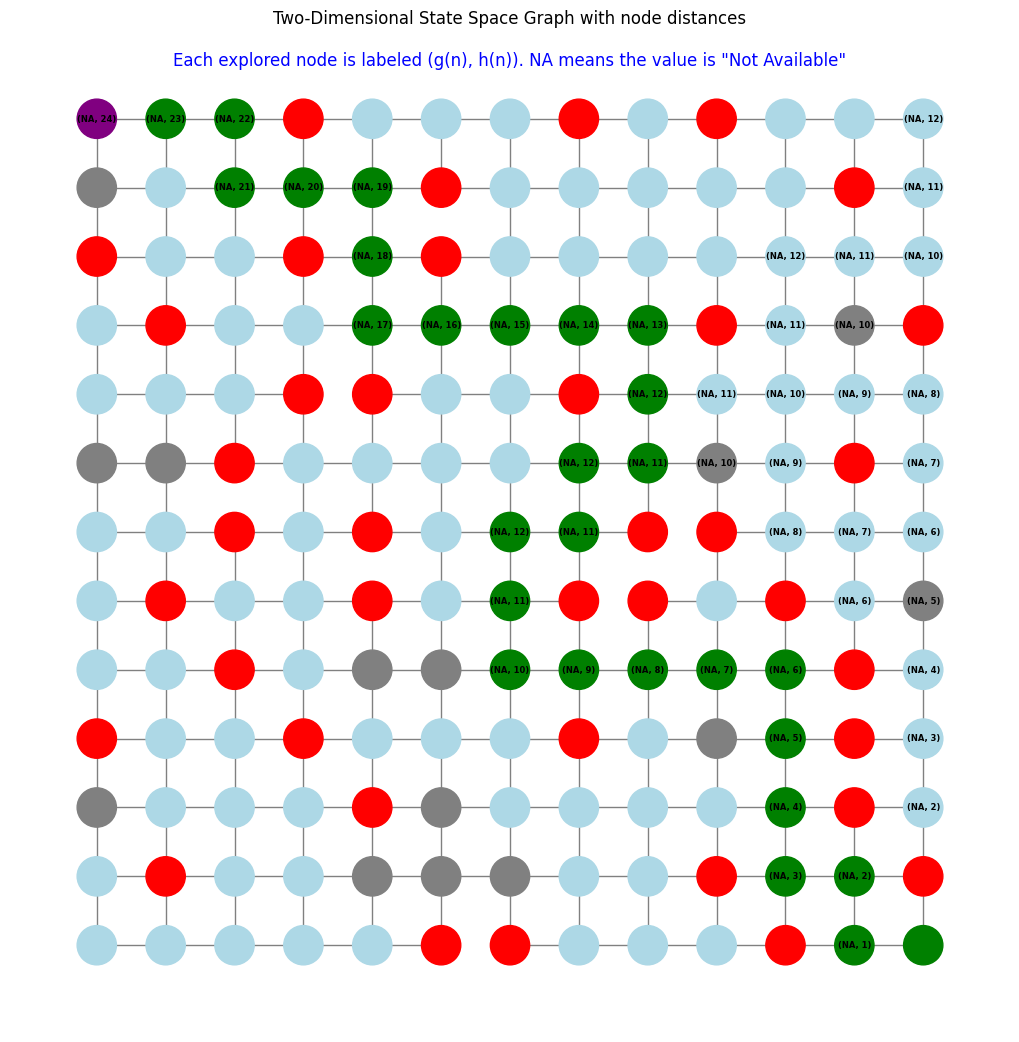

In [29]:

informed_agent = InformedSearchAgent(grid_problem3)
solution_path, explored_nodes_paths, node_distances = informed_agent.search(greedy_best_first_search, manhattan_distance)

time_case3.append(informed_agent.execution_time())
path_case3.append(len(solution_path))

print(f'Time: {informed_agent.execution_time()} seconds')
print(f"The found path is long {len(solution_path)}")

# Highlight the explored nodes in green
basic_graph = create_basic_graph(grid_problem3, grid_problem3.initial_state)
explored_graph = highlight_explored_nodes(basic_graph, solution_path)

# Plot the graph with both basic and explored nodes
plot_graph_distances(explored_graph, node_distances)

In [30]:
comparison_case3.append(algorithms)
comparison_case3.append(time_case3)
comparison_case3.append(path_case3)
df_case3 = pd.DataFrame()
df_case3['Algorithm'] = algorithms
df_case3['Execution Time'] = time_case3
df_case3['Path Length'] = path_case3
df_case3.set_index('Algorithm', inplace=True)
df_case3

Execution Time  Path Length
Algorithm                                                 
Breadth First Search (UA)            0.003752           30
Uniform Cost Search (UA)             0.008351           24
A* (IA)                              0.018075           24
Greedy Best First Search (IA)        0.001324           28

In [31]:
print("Case 1:")
print(df_case1)
print("\nCase 2:")
print(df_case2)
print("\nCase 3:")
print(df_case3)

Case 1:
                               Execution Time  Path Length
Algorithm                                                 
Breadth First Search (UA)            0.004628           40
Uniform Cost Search (UA)             0.006853           24
A* (IA)                              0.017437           24
Greedy Best First Search (IA)        0.000864           28

Case 2:
                               Execution Time  Path Length
Algorithm                                                 
Breadth First Search (UA)            0.004867           30
Uniform Cost Search (UA)             0.006419           24
A* (IA)                              0.025503           24
Greedy Best First Search (IA)        0.001802           28

Case 3:
                               Execution Time  Path Length
Algorithm                                                 
Breadth First Search (UA)            0.003752           30
Uniform Cost Search (UA)             0.008351           24
A* (IA)                       